In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer


# load and look at data

In [2]:
data = pd.read_csv('data/small_subset.csv')
data.head()

,code,product_name,countries_en,brands,abbreviated_product_name,generic_name,quantity,ecoscore_score,ecoscore_grade,nutrient_levels_tags,main_category_en,nutriscore_score,nutriscore_grade,nova_group,food_groups_en
0,3596710517510,Choco Stick chocolat au lait,"France,World",Auchan,Auchan choco stick chocolat lait 15,Bâtonnets de biscuits enrobés de chocolat au lait,0.115 kg,34.0,d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...",Stick biscuits covered with chocolate,22.0,e,4.0,"Sugary snacks,Biscuits and cakes"
1,3596710517527,Fromage à tartiner ail et fines herbes,"France,World",Pouce,Pouce fromage a tartiner ail et fin,Fromage à tartiner à l'ail et aux fines herbes,0.15 kg,NaN,unknown,NaN,NaN,NaN,unknown,NaN,NaN
2,3596710517534,AUCHAN Noir praliné et éclats de nougatine 150g,"France,World","Auchan, Auchan Gourmet",Auchan gourmet choco nr praline pep,Chocolat noir fourrage (48%) au praliné et aux...,0.15 kg,15.0,e,"en:fat-in-high-quantity,en:saturated-fat-in-hi...",Dark chocolates,21.0,e,4.0,"Sugary snacks,Chocolate products"
3,3596710517640,Epinards en branches en portions,"France,World",Auchan,Auchan epinards branches en portion,"Epinards en branches, en portions, surgelés",1 kg,NaN,unknown,NaN,NaN,NaN,unknown,NaN,NaN
4,3596710517657,AUCHAN Lait façon rocher,"France,World",Auchan,Auchan gou chocolat lait facon roch,Chocolat supérieur au lait (52%) fourrage au p...,0.15 kg,18.0,e,"en:fat-in-high-quantity,en:saturated-fat-in-hi...",Milk chocolates,24.0,e,4.0,"Sugary snacks,Chocolate products"


In [3]:
def non_na_rows(df, col):
    return df[~df[col].isna()][[col]].reset_index(drop=True)

In [4]:
non_na_rows(data, 'ecoscore_score')

,ecoscore_score
0,34.0
1,15.0
2,18.0
3,32.0
4,32.0
...,...
6948,60.0
6949,65.0
6950,60.0
6951,65.0


In [5]:
# Set the code as the index
data.set_index('code', inplace=True)

In [6]:
def clean_and_extract_column(df, column_name):
    # Clean the specified column
    df_cleaned = df[column_name].str.lower().str.strip().str.replace(r"\s+", " ").str.replace(r",\s+", ",").str.replace(r"[\*|\?|\.]", "")
    
    # Extract values into a new DataFrame with multi-index
    df_extracted = df_cleaned.str.extractall(r"(?P<{0}>[^,]+)".format(column_name))
    
    # Reset index and drop the automatically created column 'match'
    df_extracted.reset_index(inplace=True)
    df_extracted.drop('match', axis=1, inplace=True)
    
    # Remove duplicates
    df_extracted.drop_duplicates(inplace=True)
    
    # Set the original index of df as the index for df_extracted
    df_extracted.set_index('code', inplace=True)
    
    # Merge the extracted DataFrame with the original DataFrame
    df_merged = df_extracted.merge(df, right_index=True, left_index=True)
    
    return df_merged

In [7]:
# Example usage:
# Assuming 'data' is your DataFrame
df = clean_and_extract_column(data, 'countries_en')
df = clean_and_extract_column(df, 'food_groups_en')
df.head()

/var/folders/bn/jw4b363n6cz8jy9jwmhp7q0c0000gn/T/ipykernel_21878/3646603021.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cleaned = df[column_name].str.lower().str.strip().str.replace(r"\s+", " ").str.replace(r",\s+", ",").str.replace(r"[\*|\?|\.]", "")
/var/folders/bn/jw4b363n6cz8jy9jwmhp7q0c0000gn/T/ipykernel_21878/3646603021.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cleaned = df[column_name].str.lower().str.strip().str.replace(r"\s+", " ").str.replace(r",\s+", ",").str.replace(r"[\*|\?|\.]", "")


,food_groups_en_x,countries_en_x,product_name,countries_en_y,brands,abbreviated_product_name,generic_name,quantity,ecoscore_score,ecoscore_grade,nutrient_levels_tags,main_category_en,nutriscore_score,nutriscore_grade,nova_group,food_groups_en_y
code,,,,,,,,,,,,,,,,
35995,sugary snacks,italy,Il panettone,Italy,NaN,NaN,NaN,NaN,44.0,c,"en:fat-in-high-quantity,en:saturated-fat-in-hi...",Panettone,18.0,d,NaN,"Sugary snacks,Pastries"
35995,pastries,italy,Il panettone,Italy,NaN,NaN,NaN,NaN,44.0,c,"en:fat-in-high-quantity,en:saturated-fat-in-hi...",Panettone,18.0,d,NaN,"Sugary snacks,Pastries"
36377,fats and sauces,france,Green Pesto,France,NaN,NaN,NaN,NaN,38.0,d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...",Groceries,17.0,d,NaN,"Fats and sauces,Dressings and sauces"
36377,dressings and sauces,france,Green Pesto,France,NaN,NaN,NaN,NaN,38.0,d,"en:fat-in-high-quantity,en:saturated-fat-in-hi...",Groceries,17.0,d,NaN,"Fats and sauces,Dressings and sauces"
363239,salty snacks,united states,Pringles,United States,Pringles,NaN,NaN,37g,72.0,b,NaN,200,NaN,unknown,4.0,"Salty snacks,Appetizers"


# EDA 

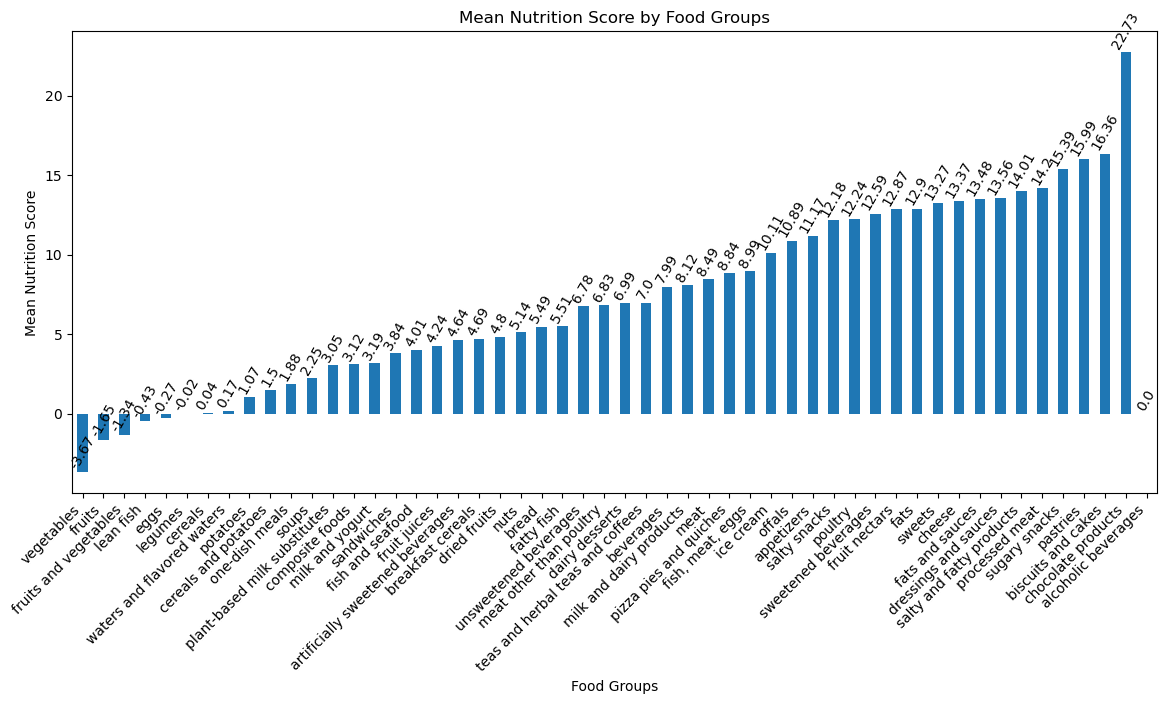

In [8]:
# Adjust figure size
plt.figure(figsize=(14, 6))

# Group by 'food_groups_en_1' and calculate mean of 'nutriscore_score'
grouped_data = df.groupby(['food_groups_en_x'])['nutriscore_score'].mean().sort_values()

# Plot bar graph
bar_plot = grouped_data.plot(kind='bar')

# Add values above bars
for i in bar_plot.patches:
    bar_plot.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.05, \
                  round(i.get_height(), 2), ha='center', va='bottom', rotation=60)

# Add labels and title
plt.xlabel('Food Groups')
plt.ylabel('Mean Nutrition Score')
plt.title('Mean Nutrition Score by Food Groups')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

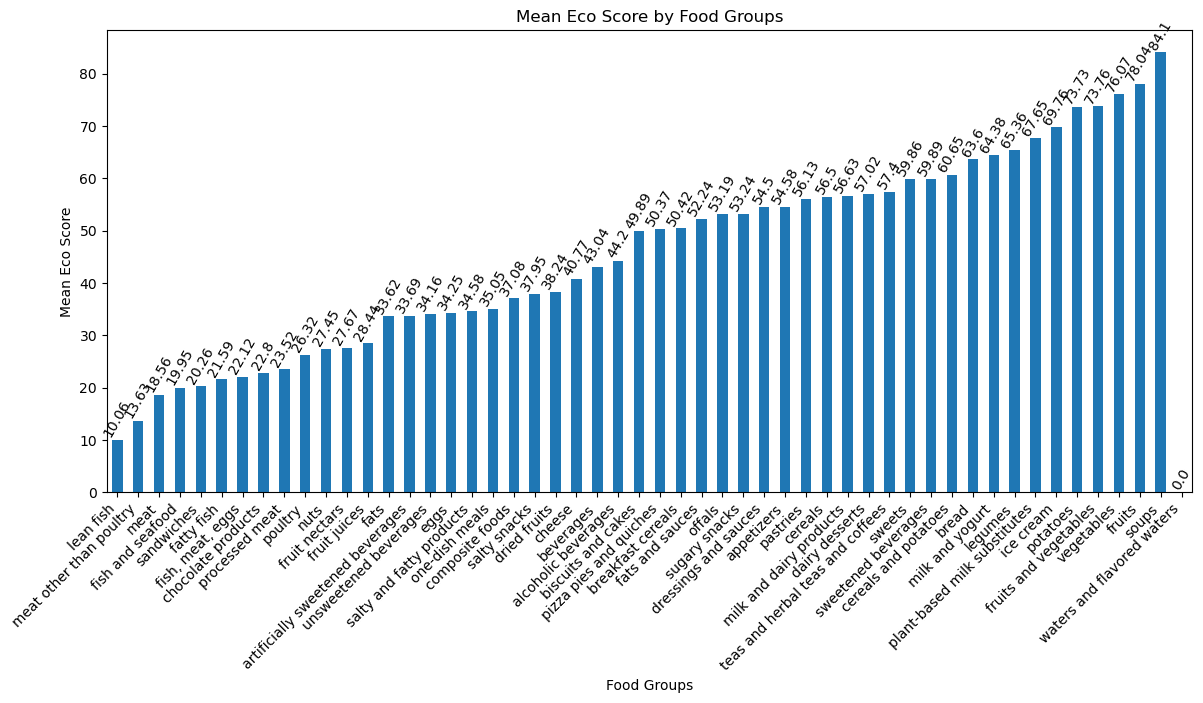

In [9]:
# Adjust figure size
plt.figure(figsize=(14, 6))

# Group by 'food_groups_en_1' and calculate mean of 'nutriscore_score'
grouped_data = df.groupby(['food_groups_en_x'])['ecoscore_score'].mean().sort_values()

# Plot bar graph
bar_plot = grouped_data.plot(kind='bar')

# Add values above bars
for i in bar_plot.patches:
    bar_plot.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.05, \
                  round(i.get_height(), 2), ha='center', va='bottom', rotation=60)

# Add labels and title
plt.xlabel('Food Groups')
plt.ylabel('Mean Eco Score')
plt.title('Mean Eco Score by Food Groups')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

# Make broader food groups

In [10]:
df.food_groups_en_x.unique()

array(['sugary snacks', 'pastries', 'fats and sauces',
       'dressings and sauces', 'salty snacks', 'appetizers',
       'milk and dairy products', 'dairy desserts', 'fats',
       'cereals and potatoes', 'bread', 'beverages',
       'sweetened beverages', 'legumes', 'chocolate products', 'sweets',
       'composite foods', 'sandwiches', 'plant-based milk substitutes',
       'one-dish meals', 'fruits and vegetables', 'vegetables',
       'dried fruits', 'biscuits and cakes', 'salty and fatty products',
       'milk and yogurt', 'fish‚ meat‚ eggs', 'fish and seafood',
       'fatty fish', 'breakfast cereals', 'cereals', 'meat',
       'meat other than poultry', 'fruit juices', 'cheese', 'fruits',
       'processed meat', 'lean fish', 'unsweetened beverages',
       'pizza pies and quiches', 'waters and flavored waters',
       'alcoholic beverages', 'eggs', 'ice cream',
       'artificially sweetened beverages', 'fruit nectars', 'potatoes',
       'poultry', 'soups', 'offals', 'teas 

In [11]:
# Define a dictionary to map specific food groups to broader categories
# (groups made to follow pnns_groups_1 from full data)
group_mapping = {
    'Unknown': ['unknown', 'na', ''],
    'Fruits and vegetables': ['fruits', 'vegetables', 'dried fruits','fruits and vegetables', 'legumes'],
    'Sugary snacks': ['sugary snacks', 'chocolate products', 'sweets', 'biscuits and cakes', 'pastries'],
    'Beverages': ['beverages', 'sweetened beverages', 'fruit juices', 'unsweetened beverages', 'waters and flavored waters', 'artificially sweetened beverages', 'fruit nectars', 'teas and herbal teas and coffees', 'alcoholic beverages'],
    'Composite foods': ['composite foods', 'sandwiches', 'pizza pies and quiches', 'one-dish meals', 'soups', 'appetizers'],
    'Fish meat eggs': ['fish and seafood', 'fatty fish', 'meat', 'meat other than poultry', 'processed meat', 'lean fish', 'eggs', 'offals', 'poultry', 'fish‚ meat‚ eggs', 'fish'],
    'Fat and sauces': ['fats and sauces', 'dressings and sauces', 'fats'],
    'Salty snacks': ['salty snacks', 'salty and fatty products', 'bread', 'nuts'],
    'Cereals and potatoes': ['cereals and potatoes', 'breakfast cereals', 'cereals', 'potatoes'],
    'Milk and dairy products': ['milk and dairy products', 'dairy desserts', 'milk and yogurt', 'cheese', 'ice cream', 'plant-based milk substitutes']
}

# Function to map food groups to their respective categories
def map_food_group(group):
    for category, food_groups in group_mapping.items():
        if group in food_groups:
            return category
    return 'Unknown'  # If no match found, assign 'Unknown'

# Create the new column
df['food_group_category'] = df['food_groups_en_x'].apply(map_food_group)
df.food_group_category.unique()

array(['Sugary snacks', 'Fat and sauces', 'Salty snacks',
       'Composite foods', 'Milk and dairy products',
       'Cereals and potatoes', 'Beverages', 'Fruits and vegetables',
       'Fish meat eggs'], dtype=object)

In [12]:
#df[df['food_group_category'] == 'Unknown']

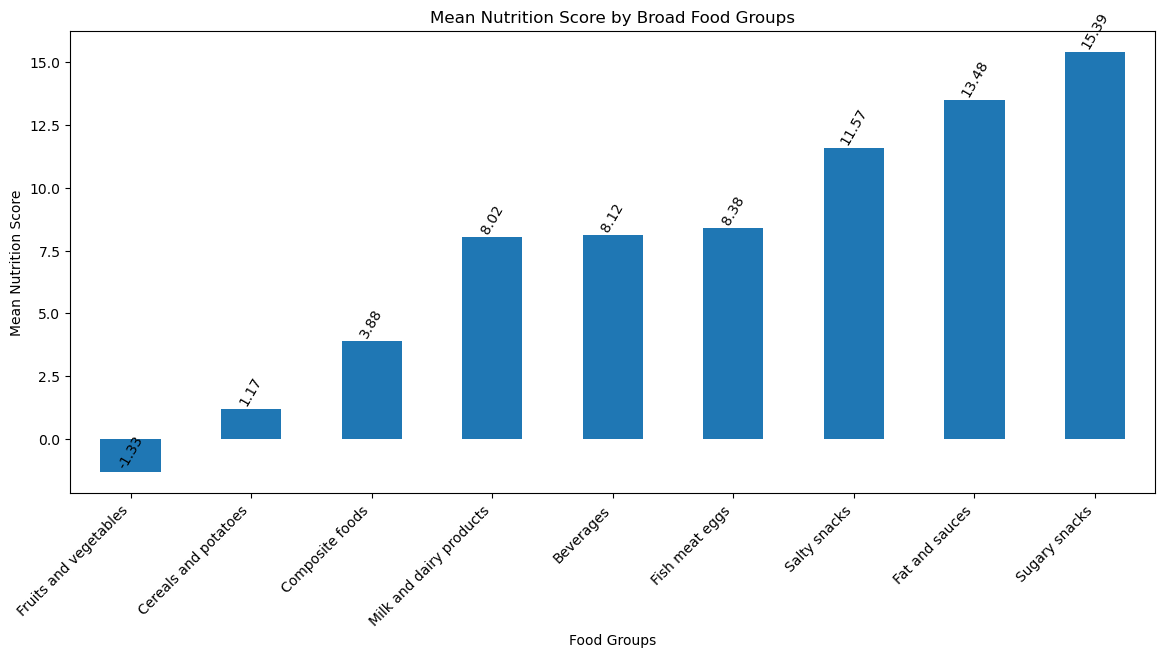

In [13]:
# Adjust figure size
plt.figure(figsize=(14, 6))

# Group by 'food_groups_en_1' and calculate mean of 'nutriscore_score'
grouped_data_nutri = df.groupby(['food_group_category'])['nutriscore_score'].mean().sort_values()

# Plot bar graph
bar_plot = grouped_data_nutri.plot(kind='bar')

# Add values above bars
for i in bar_plot.patches:
    bar_plot.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.05, \
                  round(i.get_height(), 2), ha='center', va='bottom', rotation=60)

# Add labels and title
plt.xlabel('Food Groups')
plt.ylabel('Mean Nutrition Score')
plt.title('Mean Nutrition Score by Broad Food Groups')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

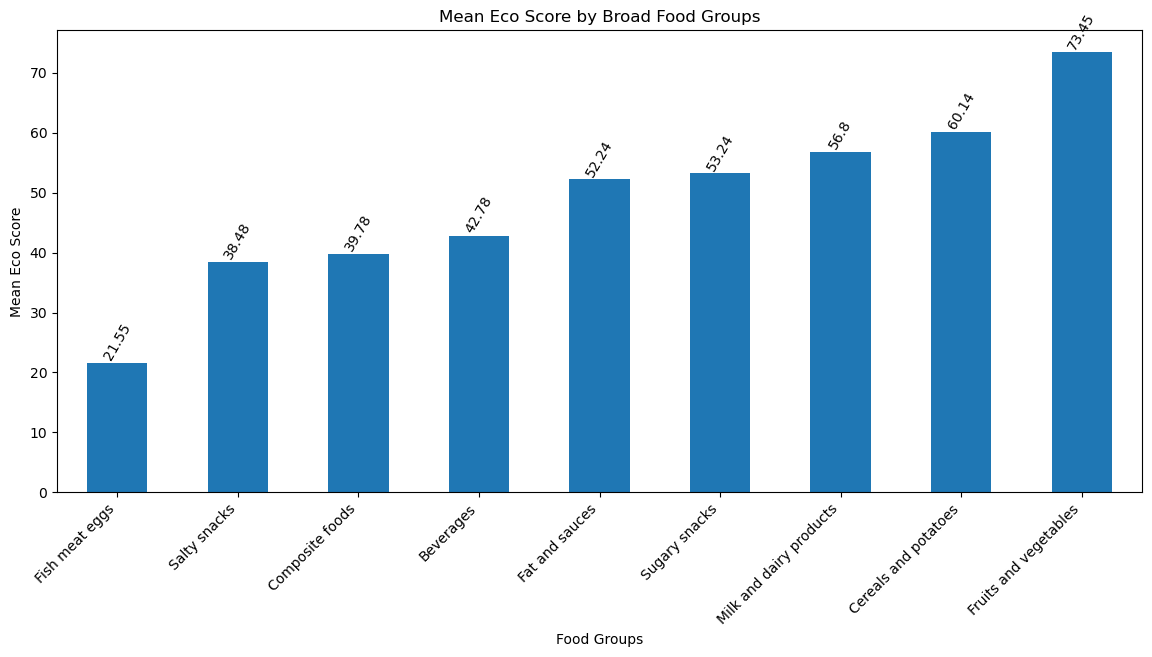

In [14]:
# Adjust figure size
plt.figure(figsize=(14, 6))

# Group by 'food_groups_en_1' and calculate mean of 'nutriscore_score'
grouped_data_eco = df.groupby(['food_group_category'])['ecoscore_score'].mean().sort_values()

# Plot bar graph
bar_plot = grouped_data_eco.plot(kind='bar')

# Add values above bars
for i in bar_plot.patches:
    bar_plot.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.05, \
                  round(i.get_height(), 2), ha='center', va='bottom', rotation=60)

# Add labels and title
plt.xlabel('Food Groups')
plt.ylabel('Mean Eco Score')
plt.title('Mean Eco Score by Broad Food Groups')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

# Spider plot

In [15]:
# Group by 'broad_food_group' and calculate mean of 'ecoscore_score' and 'nutriscore_score'
grouped_data_eco = df.groupby(['food_group_category'])['ecoscore_score'].mean().sort_values()
grouped_data_nutri = df.groupby(['food_group_category'])['nutriscore_score'].mean().sort_values()

# Combine the two series into one DataFrame
spider_df = pd.concat([grouped_data_eco, grouped_data_nutri], axis=1)
spider_df.columns = ['Mean Eco Score', 'Mean Nutrition Score']
spider_df

,Mean Eco Score,Mean Nutrition Score
food_group_category,,
Fish meat eggs,21.554395,8.377425
Salty snacks,38.477660,11.569138
Composite foods,39.784884,3.879104
Beverages,42.777998,8.119767
Fat and sauces,52.237726,13.480370
Sugary snacks,53.244072,15.393277
Milk and dairy products,56.802738,8.022425
Cereals and potatoes,60.136727,1.172817
Fruits and vegetables,73.446231,-1.330728


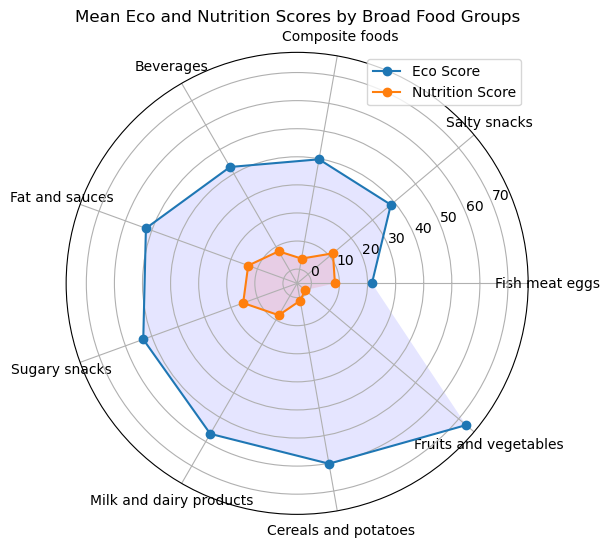

In [16]:
# Adjust figure size
plt.figure(figsize=(10, 6))

categories = spider_df.index.tolist()
values_eco = spider_df['Mean Eco Score'].values
values_nutri = spider_df['Mean Nutrition Score'].values

# Create a radar chart
ax = plt.subplot(111, polar=True)

# Calculate angles for each category
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()

# Plot eco scores
ax.plot(angles, values_eco, label='Eco Score', marker='o')
ax.fill(angles, values_eco, 'b', alpha=0.1)

# Plot nutrition scores
ax.plot(angles, values_nutri, label='Nutrition Score', marker='o')
ax.fill(angles, values_nutri, 'r', alpha=0.1)

# Add labels and title
plt.title('Mean Eco and Nutrition Scores by Broad Food Groups')
plt.legend(loc='upper right')
plt.xticks(angles, categories)

# Show plot
plt.show()

# Nutrition Score vs. Eco Score by Food Group Trends

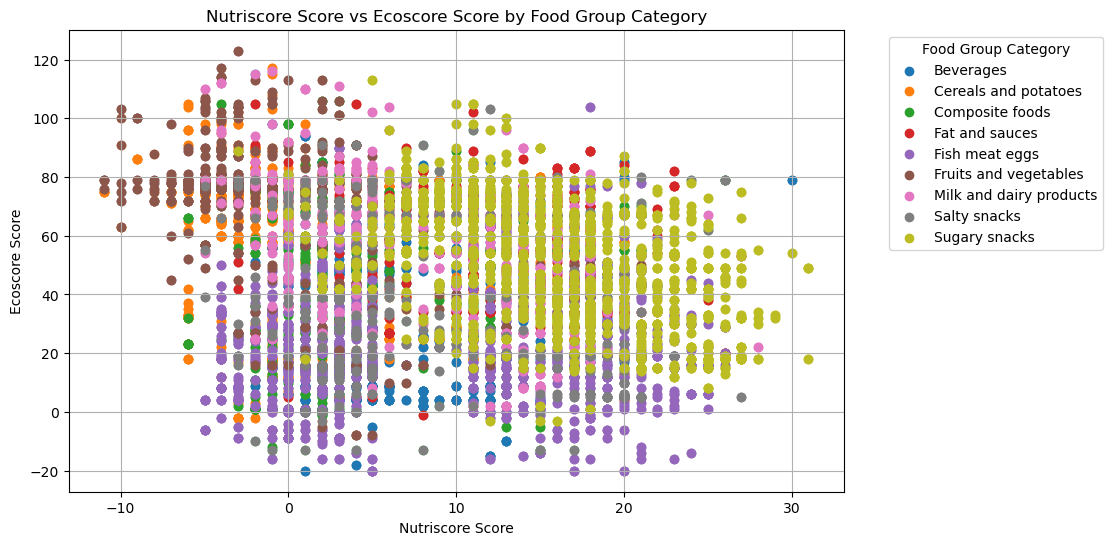

In [17]:
# Plot scatterplot colored by food_group_category
plt.figure(figsize=(10, 6))
for category, group in df.groupby('food_group_category'):
    plt.scatter(group['nutriscore_score'], group['ecoscore_score'], label=category)

plt.xlabel('Nutriscore Score')
plt.ylabel('Ecoscore Score')
plt.title('Nutriscore Score vs Ecoscore Score by Food Group Category')
plt.legend(title='Food Group Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

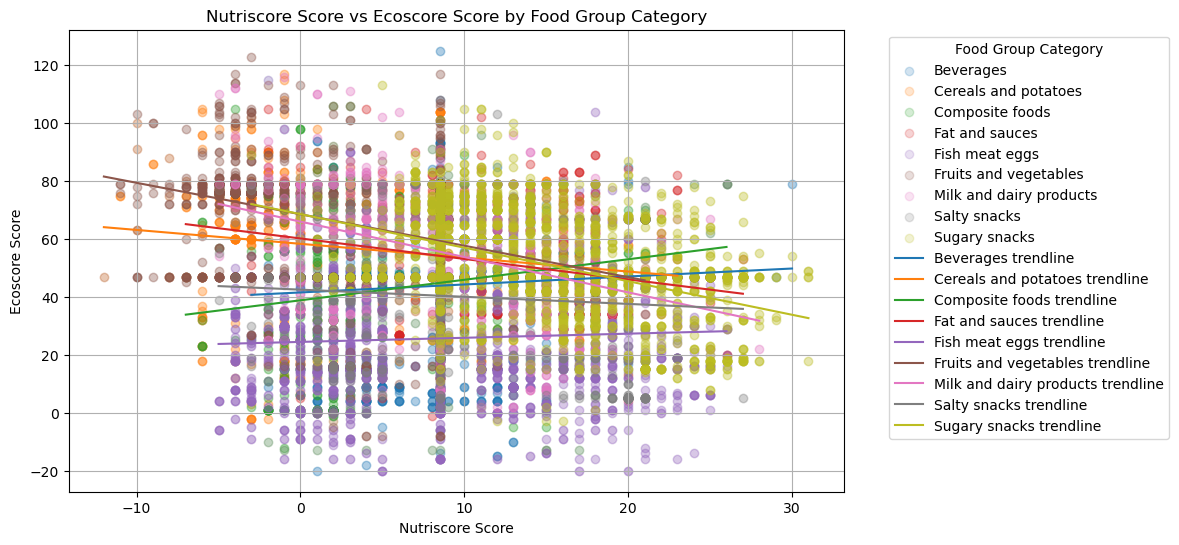

In [18]:
# add trendlines

df1 = df

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df1[['nutriscore_score', 'ecoscore_score']] = imputer.fit_transform(df1[['nutriscore_score', 'ecoscore_score']])


# Plot scatterplot colored by food_group_category
plt.figure(figsize=(10, 6))
for category, group in df1.groupby('food_group_category'):
    plt.scatter(group['nutriscore_score'], group['ecoscore_score'], label=category, alpha=0.2)
    


# Perform ridge regression and plot trend lines
for category, group in df1.groupby('food_group_category'):
    X = group[['nutriscore_score']].values
    y = group['ecoscore_score'].values
    
    # Perform ridge regression
    ridge = Ridge(alpha=0.1)  # Adjust alpha as needed
    ridge.fit(X, y)
    
    # Plot trend line
    x_values = np.linspace(min(group['nutriscore_score']), max(group['nutriscore_score']), 100)
    y_values = ridge.predict(x_values.reshape(-1, 1))
    plt.plot(x_values, y_values, label=f'{category} trendline')

plt.xlabel('Nutriscore Score')
plt.ylabel('Ecoscore Score')
plt.title('Nutriscore Score vs Ecoscore Score by Food Group Category')
plt.legend(title='Food Group Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

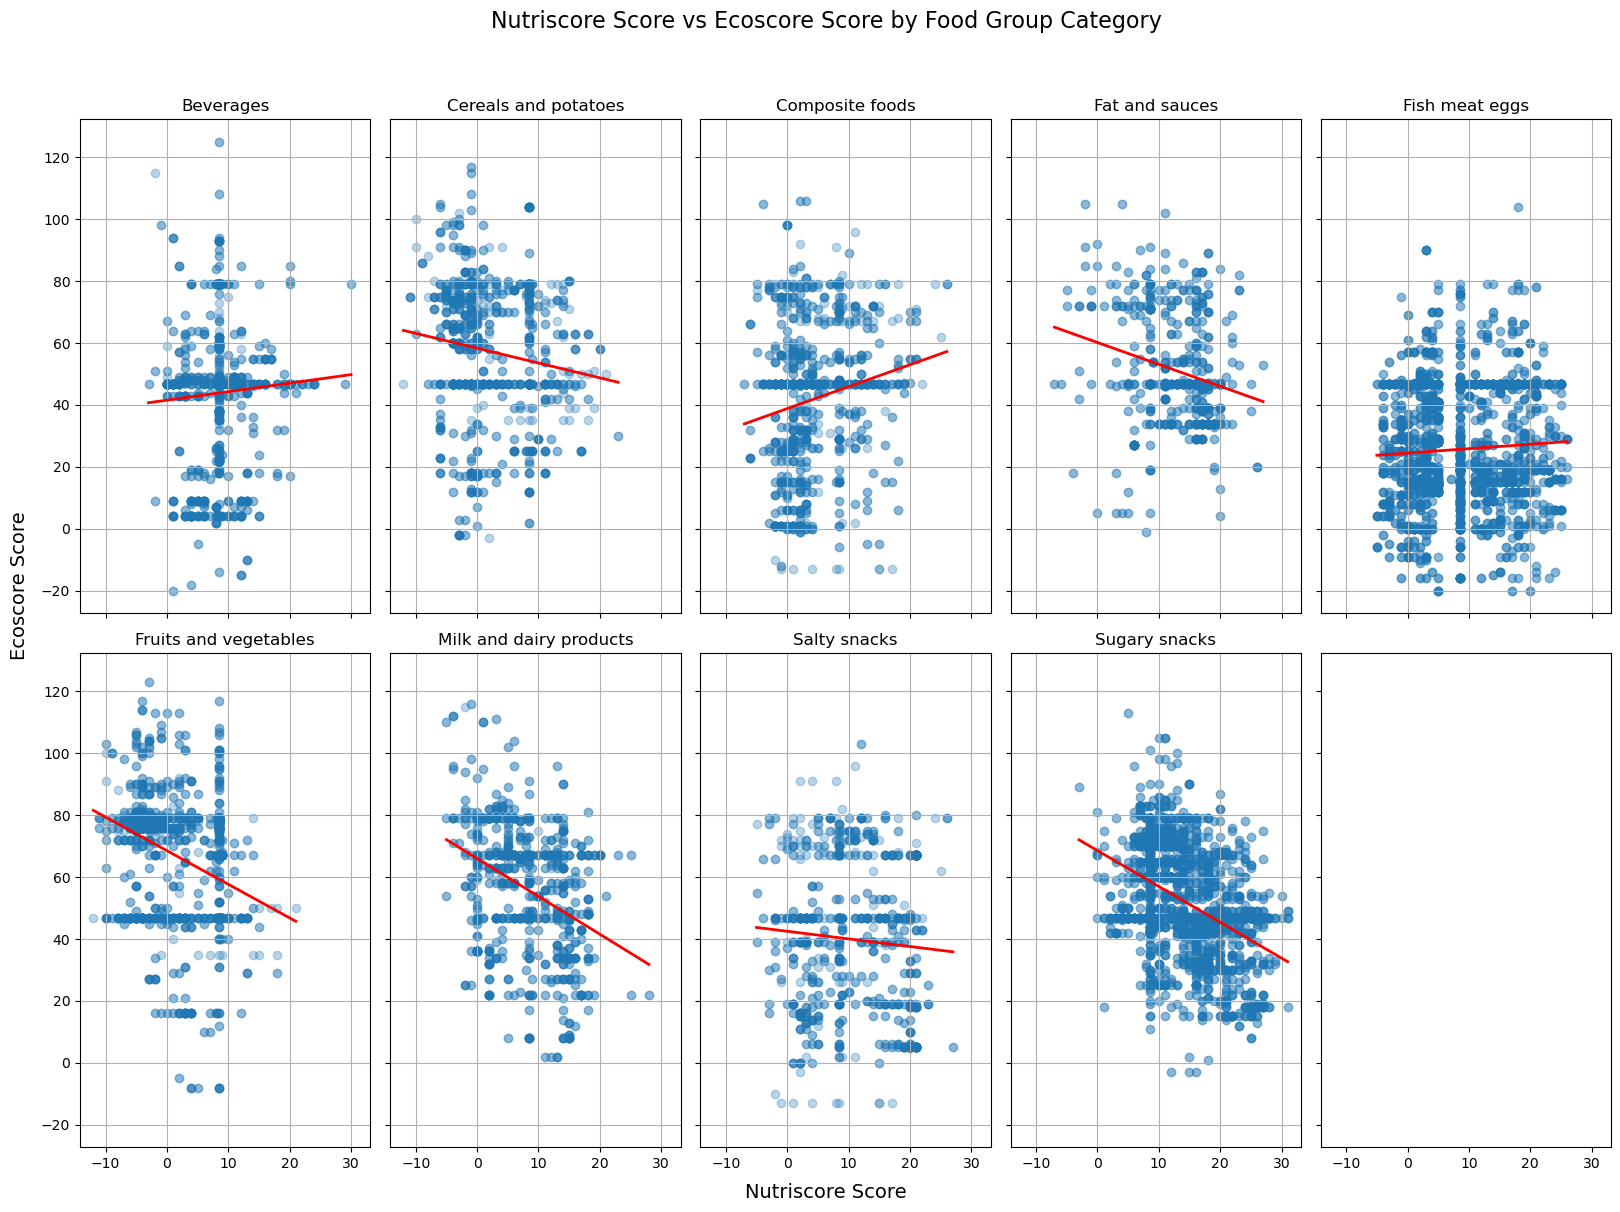

In [19]:
# Plot each food group category in its own subplot to make it more clear
fig, axs = plt.subplots(2, 5, figsize=(16, 12), sharex=True, sharey=True)
axs = axs.flatten()

for ax, (category, group) in zip(axs, df1.groupby('food_group_category')):
    ax.scatter(group['nutriscore_score'], group['ecoscore_score'], label=category, alpha=0.3)

    # Perform ridge regression and plot trend line
    X = group[['nutriscore_score']].values
    y = group['ecoscore_score'].values
    ridge = Ridge(alpha=0.1)  # Adjust alpha as needed
    ridge.fit(X, y)
    x_values = np.linspace(min(group['nutriscore_score']), max(group['nutriscore_score']), 100)
    y_values = ridge.predict(x_values.reshape(-1, 1))
    ax.plot(x_values, y_values, label=f'{category} trendline', color='red', linewidth=2)

    ax.set_title(category)
    ax.grid(True)

# Add x and y labels to the full figure
fig.text(0.5, -0.01, 'Nutriscore Score', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Ecoscore Score', va='center', rotation='vertical', fontsize=14)

fig.suptitle('Nutriscore Score vs Ecoscore Score by Food Group Category', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust subplot layout to prevent overlap
plt.show()

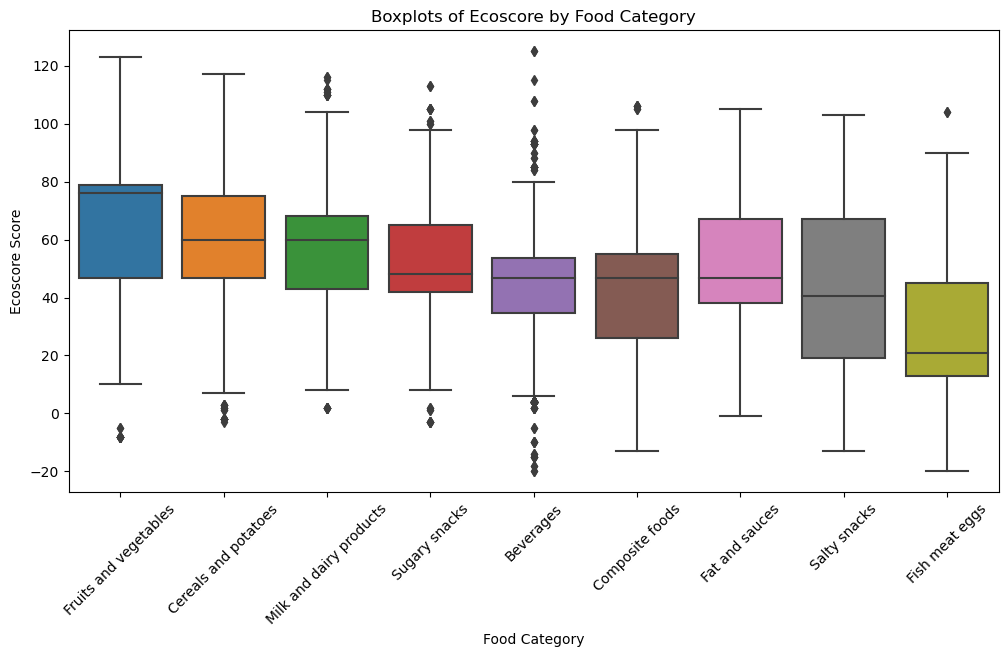

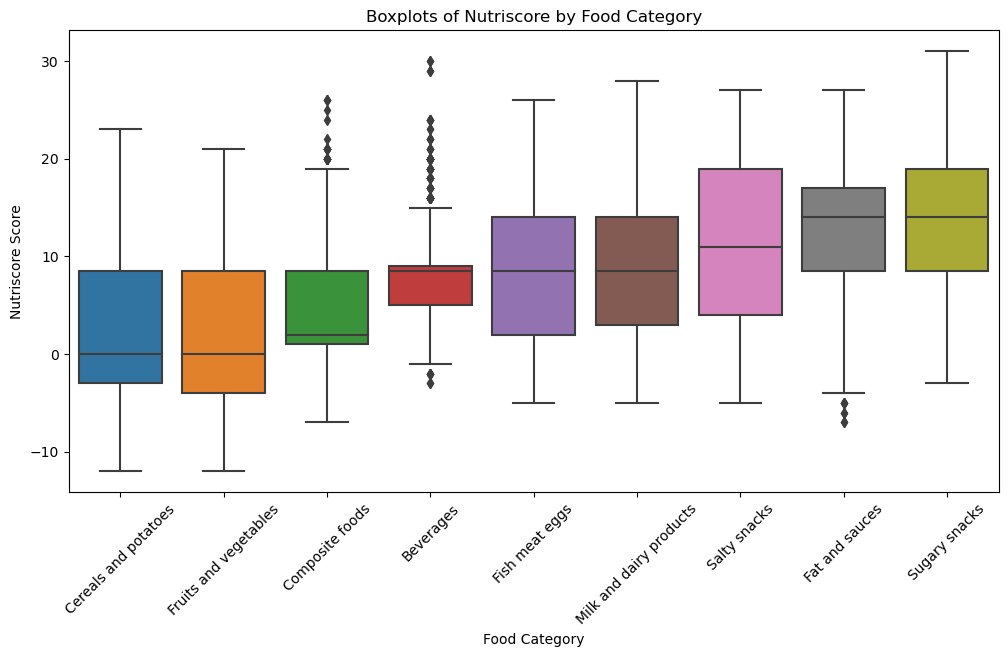

In [20]:
# Calculate median scores for each food category
median_ecoscore = df.groupby('food_group_category')['ecoscore_score'].median().sort_values(ascending=False).index
median_nutriscore = df.groupby('food_group_category')['nutriscore_score'].median().sort_values().index


# Plot boxplots for each food category based on ecoscore
plt.figure(figsize=(12, 6))
sns.boxplot(x='food_group_category', y='ecoscore_score', data=df, order=median_ecoscore)
plt.title('Boxplots of Ecoscore by Food Category')
plt.xticks(rotation=45)
plt.xlabel('Food Category')
plt.ylabel('Ecoscore Score')
plt.show()

# Plot boxplots for each food category based on nutriscore
plt.figure(figsize=(12, 6))
sns.boxplot(x='food_group_category', y='nutriscore_score', data=df, order=median_nutriscore)
plt.title('Boxplots of Nutriscore by Food Category')
plt.xticks(rotation=45)
plt.xlabel('Food Category')
plt.ylabel('Nutriscore Score')
plt.show()

In [21]:
# Note: in general, as nutriscore goes up, ecoscore goes down 
# with exception for beverages, composite foods, and fish/mean/eggs

In [22]:
# Looking at only grade a foods (only 284 in this subset that are both a in eco and nutri)

In [23]:
grade_a = df[(df['ecoscore_grade']=='a') & (df['nutriscore_grade']=='a')]
grade_a

,food_groups_en_x,countries_en_x,product_name,countries_en_y,brands,abbreviated_product_name,generic_name,quantity,ecoscore_score,ecoscore_grade,nutrient_levels_tags,main_category_en,nutriscore_score,nutriscore_grade,nova_group,food_groups_en_y,food_group_category
code,,,,,,,,,,,,,,,,,
3596710522880,beverages,poland,Bio sojowy,Poland,Auchan,NaN,NaN,1L,115.0,a,"en:fat-in-moderate-quantity,en:saturated-fat-i...",pl:napoje-sojowy,-2.0,a,1.0,"Beverages,Plant-based milk substitutes",Beverages
3596710522880,plant-based milk substitutes,poland,Bio sojowy,Poland,Auchan,NaN,NaN,1L,115.0,a,"en:fat-in-moderate-quantity,en:saturated-fat-i...",pl:napoje-sojowy,-2.0,a,1.0,"Beverages,Plant-based milk substitutes",Milk and dairy products
3596710526000,cereals and potatoes,france,Pouce lentilles 4/4,"France,World","Pouce,Auchan",Pouce lentilles 4/4,Pouce lentilles 4/4,0.8 kg,86.0,a,"en:fat-in-low-quantity,en:saturated-fat-in-low...",Cereal variety packs,-9.0,a,4.0,"Cereals and potatoes,Cereals",Cereals and potatoes
3596710526000,cereals and potatoes,world,Pouce lentilles 4/4,"France,World","Pouce,Auchan",Pouce lentilles 4/4,Pouce lentilles 4/4,0.8 kg,86.0,a,"en:fat-in-low-quantity,en:saturated-fat-in-low...",Cereal variety packs,-9.0,a,4.0,"Cereals and potatoes,Cereals",Cereals and potatoes
3596710526000,cereals,france,Pouce lentilles 4/4,"France,World","Pouce,Auchan",Pouce lentilles 4/4,Pouce lentilles 4/4,0.8 kg,86.0,a,"en:fat-in-low-quantity,en:saturated-fat-in-low...",Cereal variety packs,-9.0,a,4.0,"Cereals and potatoes,Cereals",Cereals and potatoes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3664037000029,breakfast cereals,france,Muesli croustillant banane-vanille Kokoji,France,Kokoji,NaN,Muesli croustillant,350 g,90.0,a,"en:fat-in-moderate-quantity,en:saturated-fat-i...",Mueslis with fruits,-2.0,a,1.0,"Cereals and potatoes,Breakfast cereals",Cereals and potatoes
3664037000036,cereals and potatoes,france,Muesli croustillant cacao-noisette Kokoji,France,Kokoji,NaN,Muesli Croustillant Cacao Noisette,350 g,90.0,a,"en:fat-in-moderate-quantity,en:saturated-fat-i...",Mueslis with chocolate,-3.0,a,1.0,"Cereals and potatoes,Breakfast cereals",Cereals and potatoes
3664037000036,breakfast cereals,france,Muesli croustillant cacao-noisette Kokoji,France,Kokoji,NaN,Muesli Croustillant Cacao Noisette,350 g,90.0,a,"en:fat-in-moderate-quantity,en:saturated-fat-i...",Mueslis with chocolate,-3.0,a,1.0,"Cereals and potatoes,Breakfast cereals",Cereals and potatoes


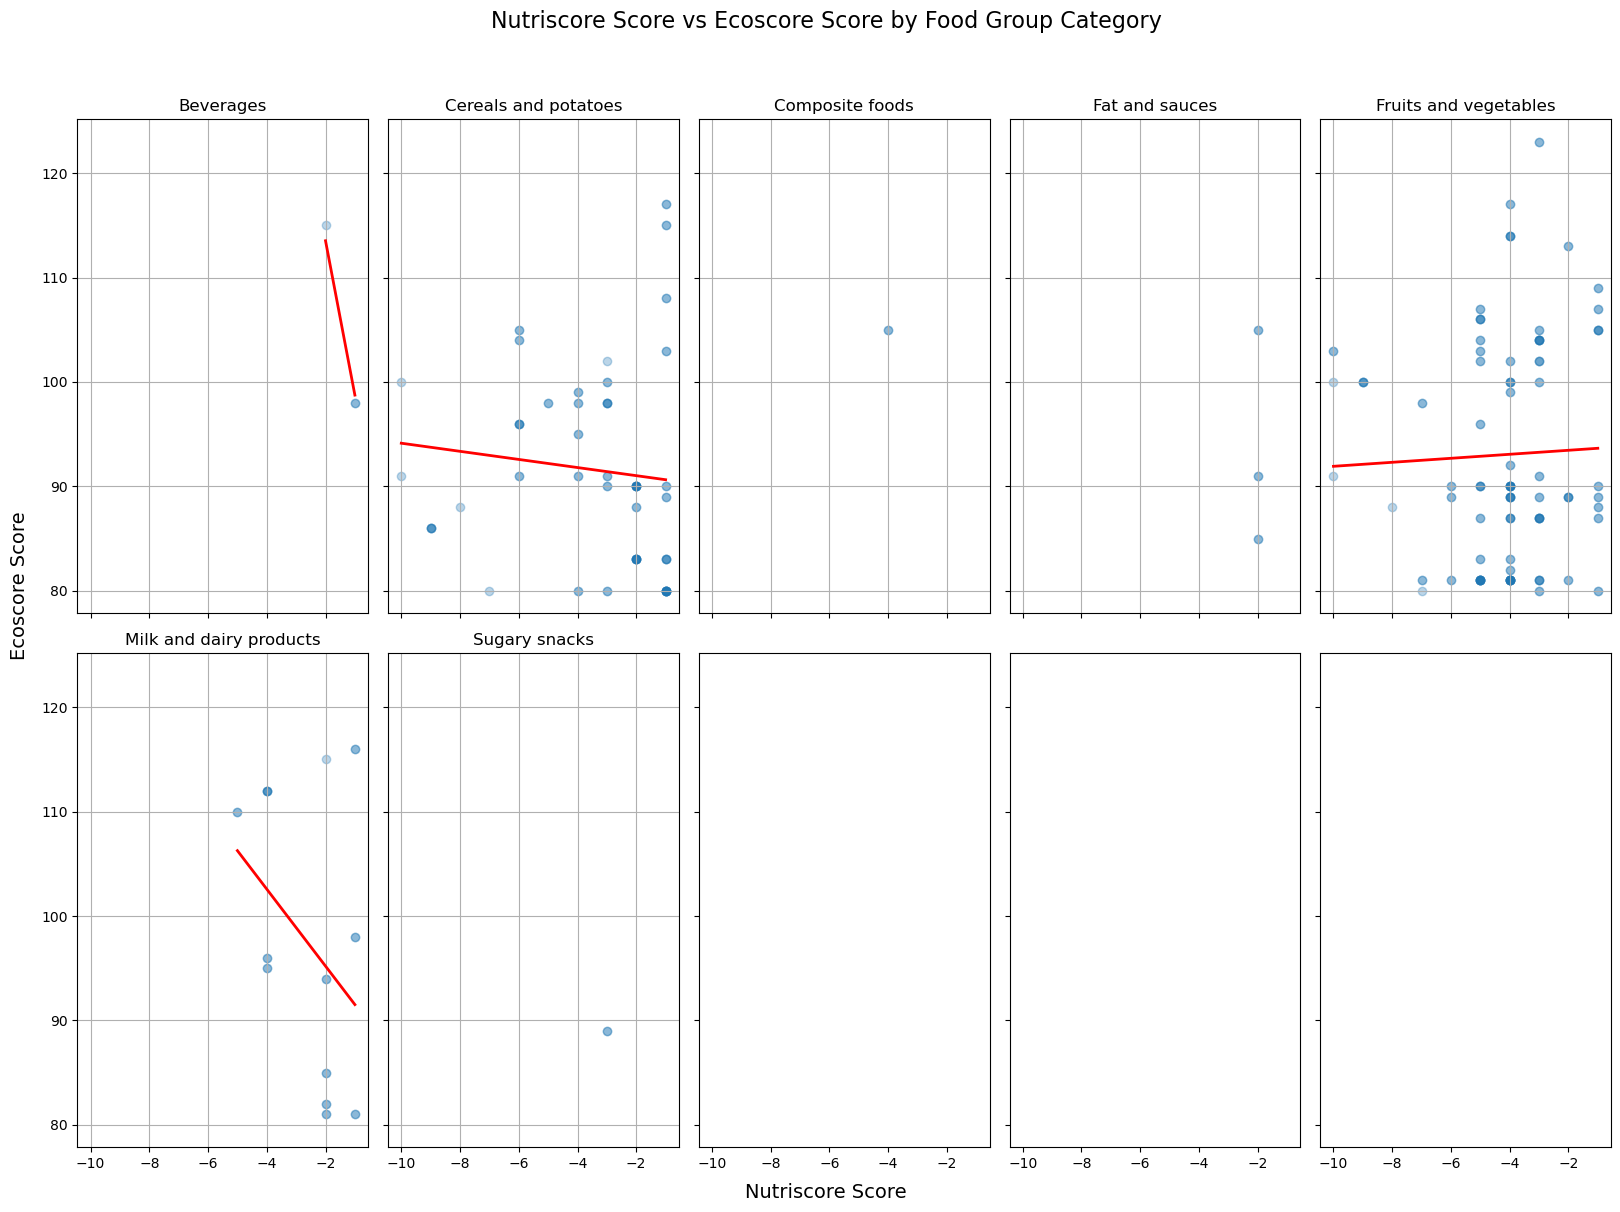

In [24]:
# Plot each food group category in its own subplot to make it more clear
fig, axs = plt.subplots(2, 5, figsize=(16, 12), sharex=True, sharey=True)
axs = axs.flatten()

for ax, (category, group) in zip(axs, grade_a.groupby('food_group_category')):
    ax.scatter(group['nutriscore_score'], group['ecoscore_score'], label=category, alpha=0.3)

    # Perform ridge regression and plot trend line
    X = group[['nutriscore_score']].values
    y = group['ecoscore_score'].values
    ridge = Ridge(alpha=0.1)  # Adjust alpha as needed
    ridge.fit(X, y)
    x_values = np.linspace(min(group['nutriscore_score']), max(group['nutriscore_score']), 100)
    y_values = ridge.predict(x_values.reshape(-1, 1))
    ax.plot(x_values, y_values, label=f'{category} trendline', color='red', linewidth=2)

    ax.set_title(category)
    ax.grid(True)

# Add x and y labels to the full figure
fig.text(0.5, -0.01, 'Nutriscore Score', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Ecoscore Score', va='center', rotation='vertical', fontsize=14)

fig.suptitle('Nutriscore Score vs Ecoscore Score by Food Group Category', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust subplot layout to prevent overlap
plt.show()

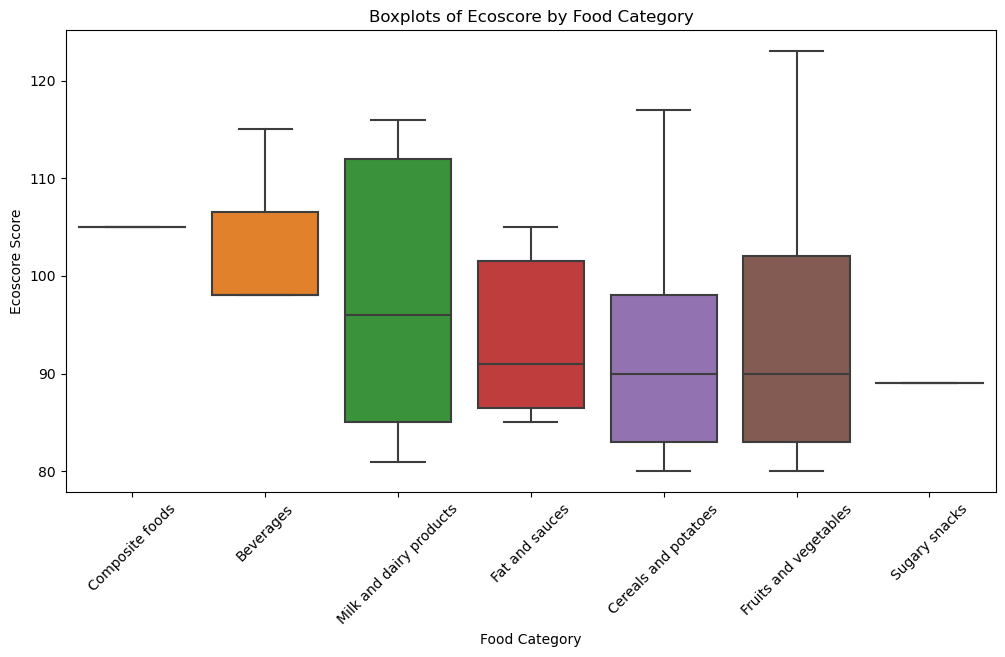

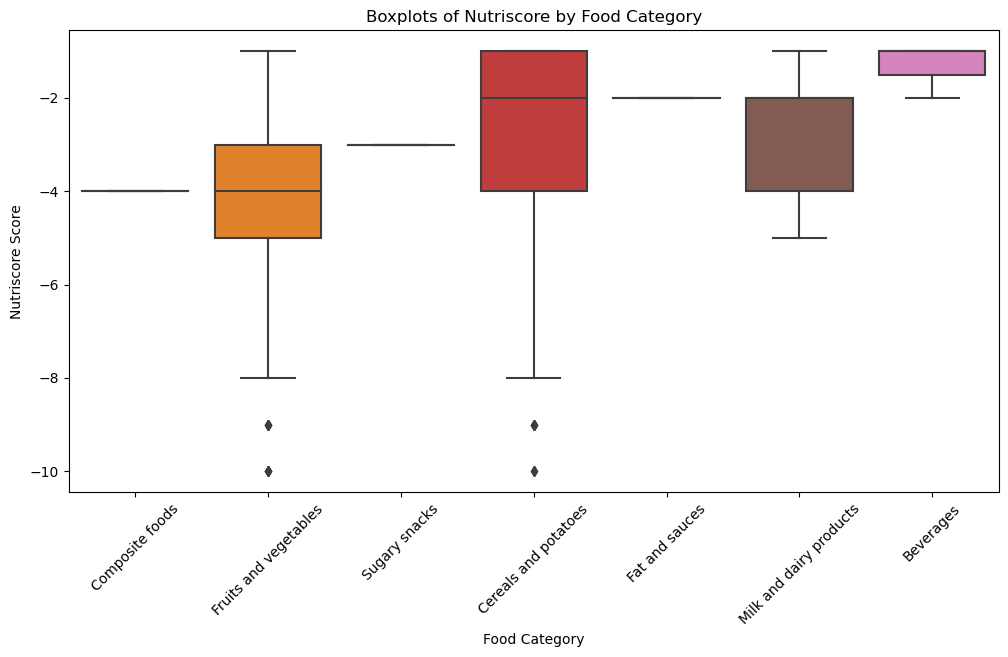

In [25]:
# Calculate median scores for each food category
median_ecoscore = grade_a.groupby('food_group_category')['ecoscore_score'].median().sort_values(ascending=False).index
median_nutriscore = grade_a.groupby('food_group_category')['nutriscore_score'].median().sort_values().index

# Plot boxplots for each food category based on ecoscore
plt.figure(figsize=(12, 6))
sns.boxplot(x='food_group_category', y='ecoscore_score', data=grade_a, order=median_ecoscore)
plt.title('Boxplots of Ecoscore by Food Category')
plt.xticks(rotation=45)
plt.xlabel('Food Category')
plt.ylabel('Ecoscore Score')
plt.show()

# Plot boxplots for each food category based on nutriscore
plt.figure(figsize=(12, 6))
sns.boxplot(x='food_group_category', y='nutriscore_score', data=grade_a, order=median_nutriscore)
plt.title('Boxplots of Nutriscore by Food Category')
plt.xticks(rotation=45)
plt.xlabel('Food Category')
plt.ylabel('Nutriscore Score')
plt.show()

# Now look at top brands, products, countries

In [26]:
# Get the top occurencies function
def get_top_occurencies(df, cols, n=10):
    count = df.groupby(cols).size().sort_values(ascending=False)
    count_percent = round(count / df.shape[0] * 100, 2)
    return pd.DataFrame({'count': count, 'count %': count_percent}).head(n)

In [27]:
get_top_occurencies(df, 'countries_en_x', n=10)
### IMPORTANT TO NOTE: >90% of data is from france in this subset!!

,count,count %
countries_en_x,,
france,16340,90.26
world,419,2.31
switzerland,369,2.04
germany,201,1.11
belgium,144,0.80
united kingdom,85,0.47
spain,84,0.46
united states,59,0.33
italy,49,0.27


In [28]:
get_top_occurencies(df, 'product_name', n=10)
# dang, the sugar subset of data had a product_name_en column that small.csv doesnt have... 
# most of these are in french bc 90% of data is from france! Important to note

,count,count %
product_name,,
Mayonnaise,60,0.33
Soupe de poissons,32,0.18
Chocolat,28,0.15
Dos de cabillaud,26,0.14
Bloc de foie gras de canard,24,0.13
Pavés de saumon,24,0.13
Pruneaux d'Agen,22,0.12
Donuts,20,0.11
Blanc de poulet,20,0.11


In [29]:
get_top_occurencies(df, 'brands', n=10)

,count,count %
brands,,
Andros,1150,6.35
Bonne Maman,876,4.84
Auchan,735,4.06
La belle-iloise,702,3.88
Findus,634,3.50
Prix Mini,450,2.49
Comtesse du Barry,435,2.40
Brossard,342,1.89
"Tradilège,Marque Repère",302,1.67
